# Von Karman beam around the buckled state


We are using the Taylor coefficients extracted via SSMTool using the graph style parametrization. 

In [1]:
import numpy as np
from scipy.io import loadmat

In [2]:
import matplotlib.pyplot as plt

In [14]:
from taylor_to_pade.matlab_integration import *
from taylor_to_pade.approximant import TaylorSeries, PadeApproximant

In [4]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 13, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

## Load SSM coefficients

In [5]:
import numpy as np
from scipy.io import loadmat
mat = loadmat('vonkarman_buckled_order18.mat')


In [6]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)
base = [p1,p2]

In [7]:
import taylor_to_pade

In [8]:
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']

In [9]:
matt = mat['W_0'][0]
W0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'W_0') # get reduced dyn
parametrization_expressions = reduced_to_full(var, W0)

In [10]:
outdof = 34

In [11]:
parametrization_expressions = [parametrization_expressions[outdof],
            parametrization_expressions[17],
            parametrization_expressions[18]]

In [12]:
R0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'R_0') # get reduced dyn
reduced_dynamics_expressions = taylor_to_pade.matlab_integration.reduced_to_full(var, R0)

In [13]:
parametrization_18 = taylor_to_pade.utils.generate_list_of_taylor_approximants(parametrization_expressions, base,
                                                            max_order = 18)
red_dynamics_18 = taylor_to_pade.utils.generate_list_of_taylor_approximants(reduced_dynamics_expressions, base, max_order = 18)


## Unforced system

We have extracted the SSM-reduced dynamics near the saddle-type unstable fixed point. We now see if the dynamics captures the nontrivial buckled states.

In [15]:
xx = np.linspace(-1e-1, 1e-1, 100)

XX, YY = np.meshgrid(xx, xx)


In [16]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [17]:
parametrization_pade = taylor_to_pade.utils.generate_list_of_pade_approximants(parametrization_18, base,
                                                order_num = 3,
                                                order_denom = 3,
                                                use_robust = True)


In [18]:
UU = red_dynamics_18[0].evaluate(pts).reshape(XX.shape)
VV = red_dynamics_18[1].evaluate(pts).reshape(XX.shape)
zz = parametrization_18[0].evaluate(pts).reshape(XX.shape)
zz_pade = parametrization_pade[0].evaluate(pts).reshape(XX.shape)


(-0.1, 0.1)

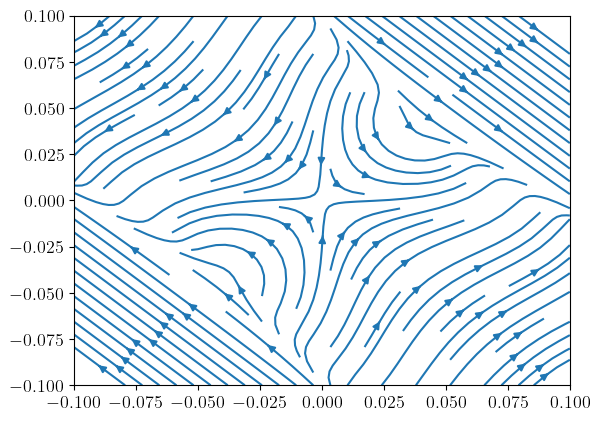

In [19]:
plt.streamplot(XX, YY, UU, VV)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


The Taylor series diverges outside a small domain near the saddle fixed point. No trace of the stable fixed points is visible. 

## Reduced dynamics on the gSSM

In [20]:
red_dyn_pade = taylor_to_pade.utils.generate_list_of_pade_approximants(red_dynamics_18, base,
                                                                       order_num = 6, 
                                                                       order_denom = 6, use_robust = True)


In [21]:
xx = np.linspace(-1e-1, 1e-1, 100)

XX, YY = np.meshgrid(xx, xx)


In [22]:
pts = np.vstack((XX.ravel(), YY.ravel())).T

In [23]:
UU = red_dyn_pade[0].evaluate(pts).reshape(XX.shape)
VV = red_dyn_pade[1].evaluate(pts).reshape(XX.shape)

(-0.1, 0.1)

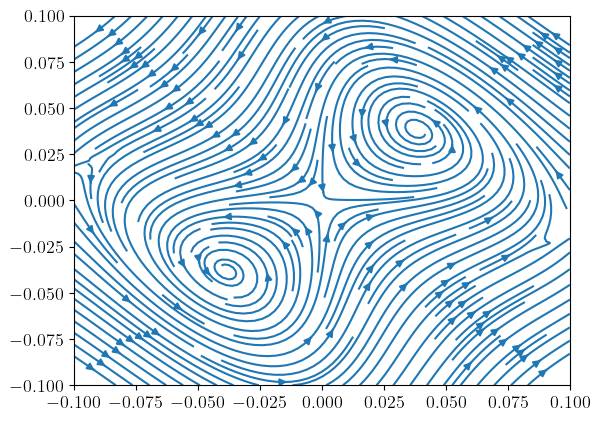

In [24]:
plt.streamplot(XX, YY, UU, VV, density = 2)
plt.xlim(xx.min(), xx.max())
plt.ylim(xx.min(), xx.max())


The gSSM-model, however, does capture both buckled states. 

### Load the unforced data

We load trajectories of the full system that converge to the buckled states along the unstable manifold of the saddle. 

In [25]:
dat = loadmat('dataVK_buckled_unforced_mid.mat')

In [26]:
W_1 = W0[0]['coeffs']

To obtain the reduced coordinates, we must project to the SSM. That is, we must have

$$
\mathbf{W}_1\boldsymbol{\eta} = \mathbf{u}$$

In [27]:
plus_ = dat['sol_plus']- dat['unstable_fp'].T
minus_ = dat['sol_minus'] - dat['unstable_fp'].T


and solve for $\boldsymbol{\eta}$

In [28]:
reduced_plus = np.linalg.lstsq(W_1, plus_.T)[0]
reduced_minus = np.linalg.lstsq(W_1, minus_.T)[0]


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_38558/3020135435.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_plus = np.linalg.lstsq(W_1, plus_.T)[0]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_38558/3020135435.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_minus = np.linalg.lstsq(W_1, minus_.T)[0]


(-0.01, 0.001)

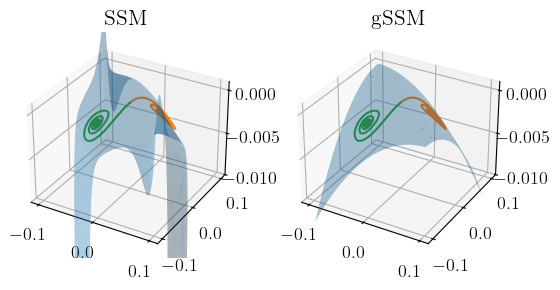

In [29]:
fig = plt.figure()
ax = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122, projection = '3d')
ax.plot_surface(XX, YY, zz, alpha = 0.4)
ax.plot(reduced_plus[0,:], reduced_plus[1,:], plus_[:,outdof])
ax.plot(reduced_minus[0,:], reduced_minus[1,:], minus_[:,outdof])
ax.set_title('SSM')
ax.set_zlim(-0.010, 0.001)
ax2.plot_surface(XX, YY, zz_pade, alpha = 0.4)
ax2.plot(reduced_plus[0,:], reduced_plus[1,:], plus_[:,outdof])
ax2.plot(reduced_minus[0,:], reduced_minus[1,:], minus_[:,outdof])
ax2.set_title('gSSM')
ax2.set_zlim(-0.010, 0.001)

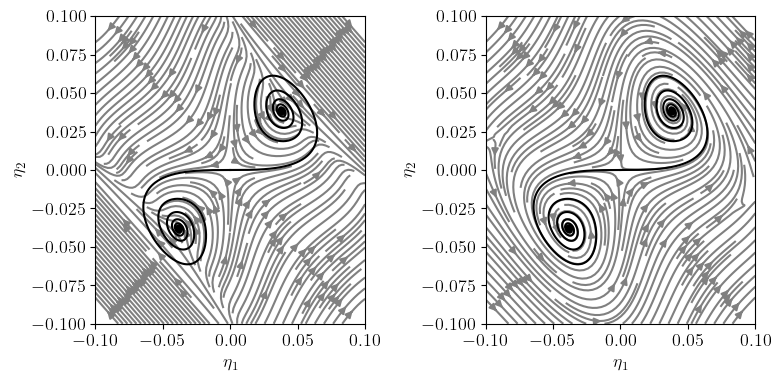

In [30]:
ff = plt.figure(figsize = (8, 4))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)
UU = red_dynamics_18[0].evaluate(pts).reshape(XX.shape)
VV = red_dynamics_18[1].evaluate(pts).reshape(XX.shape)
streamplotobject_taylor = ax.streamplot(XX, YY, UU, VV, density = 2, color='grey')
ax.plot(reduced_plus[1,:], reduced_plus[0,:], c= 'black')
ax.plot(reduced_minus[1,:], reduced_minus[0,:], c= 'black')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(xx.min(), xx.max())

UU = red_dyn_pade[0].evaluate(pts).reshape(XX.shape)
VV = red_dyn_pade[1].evaluate(pts).reshape(XX.shape)

streamplotobject_pade = ax2.streamplot(XX, YY, UU, VV, density = 2, color='grey')
ax2.plot(reduced_plus[1,:], reduced_plus[0,:] , c= 'black')
ax2.plot(reduced_minus[1,:], reduced_minus[0,:], c= 'black')
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(xx.min(), xx.max())
ax.set_xlabel('$\eta_1$')
ax2.set_xlabel('$\eta_1$')
ax.set_ylabel('$\eta_2$')
ax2.set_ylabel('$\eta_2$')
plt.tight_layout()


In [31]:
ic_plus_reduced = reduced_plus[:,0][::-1]
ic_minus_reduced = reduced_minus[:,0][::-1]


In [32]:
def odeint_pade(t, x):
    return np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()

def odeint_taylor(t, x):
    return np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()

In [33]:
coeffs_poly_1 = dict(red_dynamics_18[0].polynomial.as_coefficients_dict())
coeffs_poly_2 = dict(red_dynamics_18[1].polynomial.as_coefficients_dict())

In [34]:
from scipy.integrate import solve_ivp

In [ ]:
teval = np.linspace(0, 2, 2000)
sol_plus_pade = solve_ivp(odeint_pade, [0,2], ic_plus_reduced, t_eval = teval, method = 'DOP853')
sol_minus_pade = solve_ivp(odeint_pade, [0,2], ic_minus_reduced, t_eval = teval, method = 'DOP853')


sol_plus_taylor = solve_ivp(odeint_taylor, [0,2], ic_plus_reduced, t_eval = teval, method = 'DOP853')
sol_minus_taylor = solve_ivp(odeint_taylor, [0,2], ic_minus_reduced, t_eval = teval, method = 'DOP853')


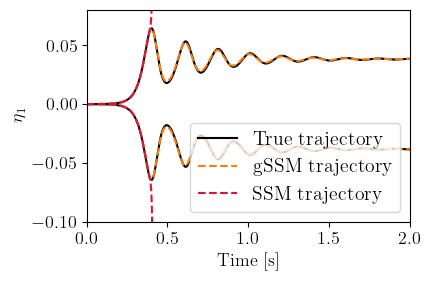

In [71]:
ff = plt.figure(figsize = (4.5,3))
ax = ff.add_subplot(111)

ax.plot(teval, reduced_minus[1,:], '-', c='black', label = 'True trajectory')

ax.plot(sol_minus_pade.t, sol_minus_pade.y[0,:], '--', c='C1', label = 'gSSM trajectory')
ax.plot(sol_minus_taylor.t, sol_minus_taylor.y[0,:], '--', c='crimson', label = 'SSM trajectory')


ax.plot(teval, reduced_plus[1,:], '-', c='black')
ax.plot(sol_plus_pade.t, sol_plus_pade.y[0,:], '--', c='C1')
ax.plot(sol_plus_taylor.t, sol_plus_taylor.y[0,:], '--', c='crimson')

ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
ax.set_ylim(-0.1, 0.08)
ax.set_xlim(0, 2)
ax.legend(loc='lower right', fontsize = 14.25)
plt.tight_layout()


# Adding periodic forcing

When we add periodic forcing to the beam near its buckled state, we observe chaotic response. The dynamics is similar to that of a Duffing oscillator. 

To leading order, we may simply project the forcing vector to the tangent space of the SSM, which results in the forced reduced dynamics

\begin{align}
   \mathbf{R}_\varepsilon(\mathbf{p}) = \mathbf{R}(\mathbf{p}) +\varepsilon\mathbf{V^*}\mathbf{f}_{ext}\cos (\Omega t),
\end{align}

with $\Omega = 25.31$

The reduced forcing vector is obtained from SSMTool as 

```matlab
f_periodic  = zeros(size(fExt)); f_periodic(18,1) = 1; % forcing on midpoint
Amp = 21.1;
Frq = 23.957894736842107; % forcing amplitude and frequency in full state space

F_f = Amp.*(M\f_periodic);
F_forced = @(t,x,w) F(t,x) + [zeros(n,1); F_f*cos(w*t)];
f_ext_vector = [zeros(n,1); F_f];
vstar_fext = left_eig'*DS.B*f_ext_vector
```

In [35]:
dat = loadmat('dataVK_buckled_forced_chaotic_mid.mat')
W_1 = W0[0]['coeffs']
traj1 = dat['sol_ep1']- dat['unstable_fp'].T
traj2 = dat['sol_ep2'] - dat['unstable_fp'].T
reduced_traj1 = np.linalg.lstsq(W_1, traj1.T)[0]
reduced_traj2 = np.linalg.lstsq(W_1, traj2.T)[0]


/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_38558/3420304566.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_traj1 = np.linalg.lstsq(W_1, traj1.T)[0]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_38558/3420304566.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reduced_traj2 = np.linalg.lstsq(W_1, traj2.T)[0]


In [36]:
ic_chaot1_reduced = reduced_traj1[:,0][::-1]
ic_chaot2_reduced = reduced_traj2[:,0][::-1]


In [37]:
frq_ = 25.30769231

In [38]:
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

First the Taylor dynamics:

In [39]:
amp_ssm =  0.2267033242968807
amp_full = 21.1154
def odeint_pade_forced(t, x):
    phase = frq_ * t
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + np.array([amp_ssm, -amp_ssm])*np.cos(frq_ * t)




In [40]:
def odeint_taylor_forced(t, x):
    autonomous = np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()
    return autonomous + np.array([amp_ssm, -amp_ssm]) * np.cos(frq_ * t)
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [41]:
sol_chaotic_taylor_1 = solve_ivp(odeint_taylor_forced, [0,0.1], ic_chaot1_reduced,method = 'DOP853', rtol = 1e-8, atol = 1e-10)
sol_chaotic_taylor_2 = solve_ivp(odeint_taylor_forced, [0,.1], ic_chaot2_reduced, method = 'DOP853', rtol = 1e-8, atol = 1e-10)

In [42]:
sol_1_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)
sol_2_pade = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot2_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8,  atol = 1e-10)



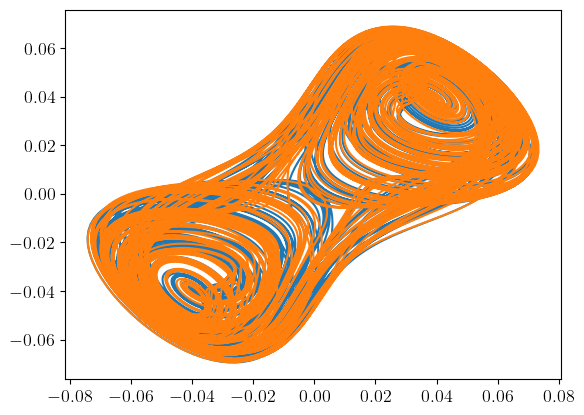

In [43]:
plt.plot(sol_1_pade.y[0,:], sol_1_pade.y[1,:], '-')
plt.plot(sol_2_pade.y[0,:], sol_2_pade.y[1,:], '-')

## Short time reconstruction and Poincare sections

In [44]:
numberPeriods = 1000
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [46]:
sol_1_pade_long = solve_ivp(odeint_pade_forced, [0,endTime], ic_chaot1_reduced, t_eval = timespan, method = 'RK45', rtol = 1e-8, atol = 1e-10)



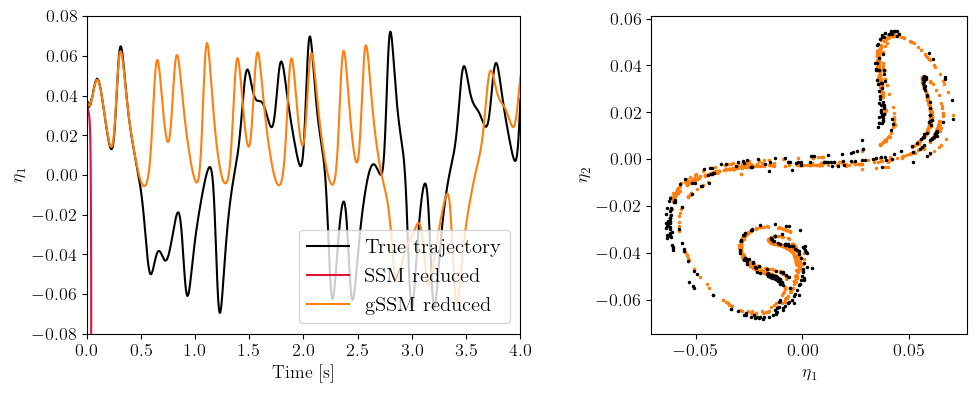

In [47]:
aspect_ratio = 443/173
width = 10.5521
ff = plt.figure(figsize = (width,width/aspect_ratio))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_chaotic_taylor_1.t, sol_chaotic_taylor_1.y[1,:], '-', c='crimson', label = 'SSM reduced')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '-', c='C1', label = 'gSSM reduced')
ax.legend(loc = 'lower right', fontsize = 15)
ax.set_ylim(-0.08, 0.08)

ax2.plot(sol_1_pade_long.y[0,::100], sol_1_pade_long.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax2.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax2.plot(sol_2_pade.y[0,::100], sol_2_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
ax2.plot(reduced_traj2[1,::100], reduced_traj2[0,::100], '.', c='black', markersize = 3, label = 'True trajectoroy')
ax2.plot(reduced_traj1[1,::100], reduced_traj1[0,::100], '.', c='black', markersize = 3, label = 'True trajectoroy')

#ax.legend(loc = 'lower right')
ax2.set_xlabel('$\eta_1$')
ax2.set_ylabel('$\eta_2$')

ax.set_xlim(0, 4)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')
ax2.set_aspect(1.1)
plt.tight_layout()


## PSD of the attractor

In [235]:
signal_true = reduced_traj1[1,:] - np.mean(reduced_traj1[1,:])
signal_pade = sol_1_pade.y[0,:] - np.mean(sol_1_pade.y[0,:])

frequencies = np.fft.fftfreq(len(signal_true), d=dt)
ff_true = np.fft.fft(signal_true)
ff_reduced = np.fft.fft(signal_pade)
positive_frequencies = frequencies[frequencies >= 0]
positive_power_spectrum_true = ff_true[frequencies >= 0]
positive_power_spectrum_reduced = ff_reduced[frequencies >= 0]

Text(0, 0.5, 'Power spectral density')

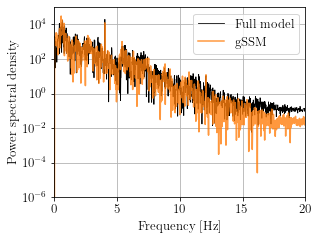

In [236]:
ff = plt.figure(figsize = (4.5,3.5))
ax = ff.add_subplot(111)

ax.semilogy(positive_frequencies, np.abs(positive_power_spectrum_true)**2, '-', c='black',label = 'Full model', linewidth =0.8)
ax.semilogy(positive_frequencies, np.abs(positive_power_spectrum_reduced)**2, '-', c='C1',label = 'gSSM', alpha = 0.8)
ax.set_xlim(0, 20)
ax.set_ylim(1e-6, 1e5)
ax.grid()
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power spectral density')



## Nonaoutonomous correction

We can also include higher-order corrections to the forced dynamics. To leading order in $\varepsilon$, but to higher order in the reduced coordinates $\mathbf{p}$, we have

\begin{equation}
    \mathbf{R}_\varepsilon(\mathbf{p}, \Phi) = \mathbf{R}(\mathbf{p}) +\varepsilon \sum_{|\mathbf{k}|=0}^{\hat{N}}\mathbf{S}_{\mathbf{k}}(\Phi) \mathbf{p}^\mathbf{k} + O(\varepsilon^2),
\end{equation}

where $\Phi=\Omega t$. The coefficients $\mathbf{S}_{\mathbf{k}}$ are also computed using SSMTool and now explicitly depend on the frequency of the forcing. 

In [48]:

mat_na = loadmat('vonkarman_buckled_mid_load_order2_nonaut.mat')


In [49]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)

In [50]:
R11 = extract_gen_new_nonautonomous(mat_na, 0,  'R1') # get reduced dyn


In [51]:
R12 = extract_gen_new_nonautonomous(mat_na, 1,  'R1') 


In [52]:
R11[1]['coeffs'] = 0*R11[1]['coeffs']
R12[1]['coeffs'] = 0*R12[1]['coeffs']

We have polynomial expressions for each harmonic: 

In [53]:
k1_expression = reduced_to_full(var, R11)
k2_expression = reduced_to_full(var, R12)

In [54]:
forcing_vector_11 = sy.lambdify([p1, p2], k1_expression[0][0], 'numpy')
forcing_vector_12 = sy.lambdify([p1, p2], k1_expression[1][0], 'numpy')
forcing_vector_21 = sy.lambdify([p1, p2], k2_expression[0][0], 'numpy')
forcing_vector_22 = sy.lambdify([p1, p2], k2_expression[1][0], 'numpy')

In [55]:
red_dynamics_nonaut_k1 = taylor_to_pade.utils.generate_list_of_taylor_approximants(k1_expression, base, max_order = 18)


In [56]:
red_dynamics_nonaut_k2 = taylor_to_pade.utils.generate_list_of_taylor_approximants(k2_expression, base, max_order = 18)


In [59]:
nonaout_pade_k1 = taylor_to_pade.utils.generate_list_of_pade_approximants(red_dynamics_nonaut_k1, base,
                                                order_num = 6,
                                                order_denom = 6,
                                                use_robust = True)

In [60]:
nonaout_pade_k2 = taylor_to_pade.utils.generate_list_of_pade_approximants(red_dynamics_nonaut_k2, base,
                                                order_num = 6,
                                                order_denom = 6,
                                                use_robust = True)

In [61]:
amp_ssm =  0.2267033242968807


In [62]:
amp_full = 21.1
def odeint_pade_forced_NA(t, x):
    phase = frq_ * t
    autonomous = np.array([red_dyn_pade[0].evaluate(x.reshape(1,-1)),
                   red_dyn_pade[1].evaluate(x.reshape(1,-1))]).ravel()
    forcing = np.array([nonaout_pade_k1[0].evaluate(x.reshape(1,-1)) * np.exp(1j*phase) 
                        + nonaout_pade_k2[0].evaluate(x.reshape(1,-1)) * np.exp(-1j*phase),
                   nonaout_pade_k1[1].evaluate(x.reshape(1,-1))*np.exp(1j*phase) + 
                       nonaout_pade_k2[1].evaluate(x.reshape(1,-1)) * np.exp(-1j*phase)]).ravel()
    return autonomous + amp_full*np.real(forcing)





In [63]:
def odeint_taylor_forced_NA(t, x):
    phase = frq_ * t
    autonomous = np.array([red_dynamics_18[0].evaluate(x.reshape(1,-1)),
                   red_dynamics_18[1].evaluate(x.reshape(1,-1))]).ravel()
    forcing = np.array([red_dynamics_nonaut_k1[0].evaluate(x.reshape(1,-1)) * np.exp(1j*phase) 
                        + red_dynamics_nonaut_k2[0].evaluate(x.reshape(1,-1)) * np.exp(-1j*phase),
                   red_dynamics_nonaut_k1[1].evaluate(x.reshape(1,-1))*np.exp(1j*phase) + 
                       red_dynamics_nonaut_k2[1].evaluate(x.reshape(1,-1)) * np.exp(-1j*phase)]).ravel()
    return autonomous + amp_full*np.real(forcing)





In [64]:
timescale = 2*np.pi/frq_
numberPeriods = 200
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [65]:
sol_1_pade_nonautonomous = solve_ivp(odeint_pade_forced_NA, [0,endTime], ic_chaot1_reduced,
                                     t_eval = timespan, method = 'DOP853', rtol = 1e-12, atol = 1e-10)
sol_2_pade_nonautonomous = solve_ivp(odeint_pade_forced_NA, [0,endTime], ic_chaot2_reduced,
                                     t_eval = timespan, method = 'DOP853', rtol = 1e-12,  atol = 1e-10)



In [66]:
sol_1_tay_nonautonomous = solve_ivp(odeint_taylor_forced_NA, [0,endTime], ic_chaot1_reduced,
                                     t_eval = timespan, method = 'DOP853', rtol = 1e-12, atol = 1e-10)
sol_2_tay_nonautonomous = solve_ivp(odeint_taylor_forced_NA, [0,endTime], ic_chaot2_reduced,
                                     t_eval = timespan, method = 'DOP853', rtol = 1e-12,  atol = 1e-10)



In [67]:
numberPeriods = 600
numberPointsPerPeriod = 100
endTime = numberPeriods*timescale;
nSamp = numberPeriods*numberPointsPerPeriod+1
dt = endTime/(nSamp-1);
timespan = np.linspace(0, endTime, nSamp)

In [68]:
sol_1_pade_nonautonomous_long = solve_ivp(odeint_pade_forced_NA, [0,endTime],
                                          ic_chaot1_reduced, t_eval = timespan,
                                          method = 'RK45', rtol = 1e-8, atol = 1e-10)



Text(0, 0.5, '$\\eta_1$')

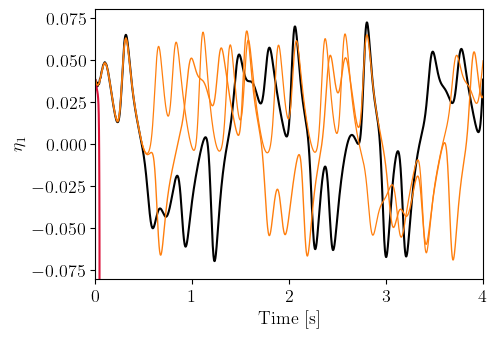

In [73]:
ff = plt.figure(figsize = (5,3.5))
ax = ff.add_subplot(111)

ax.plot(sol_1_pade_nonautonomous.t, reduced_traj1[0,:], '-', c='black', label = 'True trajectory')
ax.plot(sol_chaotic_taylor_1.t, sol_chaotic_taylor_1.y[1,:], '-', c='crimson', label = 'Reduced trajectory (Taylor)')
ax.plot(sol_1_pade_nonautonomous.t, sol_1_pade.y[1,:], '-',linewidth = 0.9,  c='C1')
ax.plot(sol_1_pade_nonautonomous.t, sol_1_pade_nonautonomous.y[1,:], '-',linewidth =1,  c='C1')
ax.set_xlim(0, 4)
ax.set_ylim(-0.08, 0.08)

ax.set_xlabel('Time [s]')
ax.set_ylabel('$\eta_1$')


In [80]:
violet_color = [0.7148491318692479, 0.02807663432018004, 0.5118115037156341]

In [74]:
err1 = np.abs(reduced_traj1[0,:] - sol_1_pade.y[1,:])
err2 = np.abs(reduced_traj1[0,:] - sol_1_pade_nonautonomous.y[1,:])


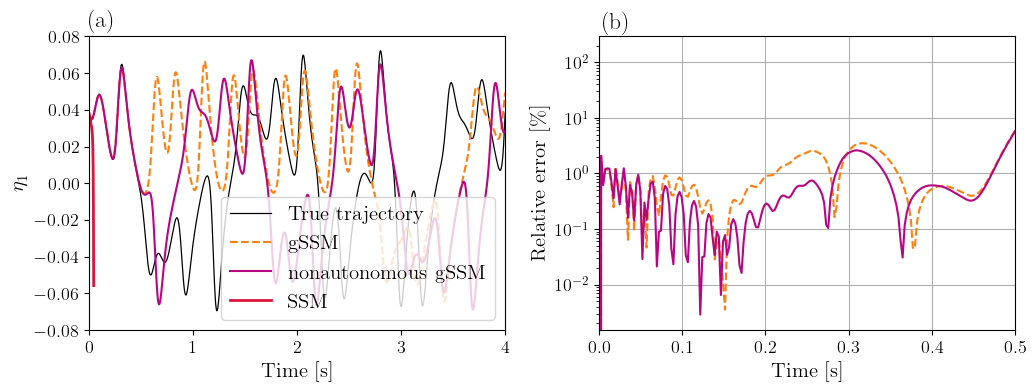

In [82]:
aspect_ratio = 443/173
width = 10.5521
ff = plt.figure(figsize = (width,width/aspect_ratio))
ax = ff.add_subplot(121)
ax2 = ff.add_subplot(122)

ax.plot(sol_1_pade.t, reduced_traj1[0,:], '-', c='black', linewidth = 0.9,  label = 'True trajectory')
ax.plot(sol_1_pade.t, sol_1_pade.y[1,:], '--', c='C1',  linewidth = 1.5, label = 'gSSM')
ax.plot(sol_1_pade_nonautonomous.t, sol_1_pade_nonautonomous.y[1,:], '-', c=violet_color, label = 'nonautonomous gSSM')
ax.plot(sol_1_tay_nonautonomous.t, sol_1_tay_nonautonomous.y[1,:], '-',linewidth = 2, label = 'SSM', c='crimson')
#ax.plot(timespan, sol_1_pade_nonautonomous.y[1,:], '-',linewidth =1,  c=color_orange)
ax.legend(loc = 'lower right', fontsize = 15)
ax.set_ylim(-0.08, 0.08)


# ax2.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
# ax2.plot(sol_1_pade_long.y[0,::100], sol_1_pade_long.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')
# ax2.plot(sol_1_pade.y[0,::100], sol_1_pade.y[1,::100], '.', c='C1', markersize = 3, label = 'Reduced trajectory (Padé)')

ax2.semilogy(sol_1_pade_nonautonomous.t, 100*err1/np.max(reduced_traj1[0,:]), '--', c='C1')
ax2.semilogy(sol_1_pade_nonautonomous.t, 100*err2/np.max(reduced_traj1[0,:]), '-',  c=colors[2])
ax2.set_xlim(0, 0.5)
ax2.grid()
#ax.legend(loc = 'lower right')
ax2.set_xlabel('Time [s]', fontsize = 15)
ax2.set_ylabel('Relative error [\%]',fontsize = 15)
ax.text(0, 0.085, '(a)', fontsize = 17)
ax2.text(0.005, 400, '(b)', fontsize = 17)

ax.set_xlim(0, 4)
#ax2.set_xlim(0, 15)
ax.set_xlabel('Time [s]', fontsize = 15)
ax.set_ylabel('$\eta_1$',fontsize = 15)
#ax2.set_aspect(1.1)
plt.tight_layout()
#plt.savefig('figs/chaotic_nonautonomous_.pdf',bbox_inches='tight')


In [233]:
signal_true = reduced_traj1[1,:] - np.mean(reduced_traj1[1,:])
signal_pade = sol_1_pade_nonautonomous.y[0,:] - np.mean(sol_1_pade_nonautonomous.y[0,:])

frequencies = np.fft.fftfreq(len(signal_true), d=dt)
ff_true = np.fft.fft(signal_true)
ff_reduced = np.fft.fft(signal_pade)
positive_frequencies = frequencies[frequencies >= 0]
positive_power_spectrum_true = ff_true[frequencies >= 0]
positive_power_spectrum_reduced = ff_reduced[frequencies >= 0]

Text(0, 0.5, 'Power spectral density')

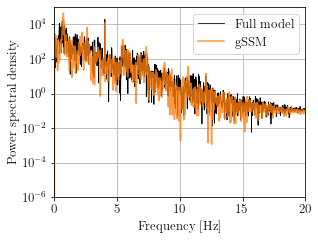

In [234]:
ff = plt.figure(figsize = (4.5,3.5))
ax = ff.add_subplot(111)

ax.semilogy(positive_frequencies, np.abs(positive_power_spectrum_true)**2, '-', c='black',label = 'Full model', linewidth =0.8)
ax.semilogy(positive_frequencies, np.abs(positive_power_spectrum_reduced)**2, '-', c='C1',label = 'gSSM', alpha = 0.8)
ax.set_xlim(0, 20)
ax.set_ylim(1e-6, 1e5)
ax.grid()
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power spectral density')

